# Figures 8,9, A1 and S3: Perturbation Experiments

This notebook will reproduce Figures 8, 9, A1, and S3 from  E. Boland et al. 2025 (doi to come). This requires input datafiles from the ECCOv4 solution and perturbation simulations based on the ECCOv4 solution to run - please see the README for details.

The datafiles were created as follows:
- xx_tauu.0000000129.data.{pert}_{pert_sign}, in ../other_data, were created using make_perts.py
- m_horflux_fw_denm.0000000129.data/meta and m_horflux_vol_denm.0000000129.data/meta, found in {EXPDIR}/{pert},
  are generated by running the ECCOv4r4 solution using the perturbation fields xx_tauu.0000000129.data.{pert}_{pert_sign}.
- pert_10y_tauu_{pert}JANpulse{sign}_Den_2dtransports.nc, in {DATA_DIR}/perts/, were created using denmark_strait_perttransports.py
- Denmark_Strait_vars.nc and Denmark_Strait_halocline.nc, in {DATA_DIR}, were created using denmark_strait_ctrlvars.py
- Denmark_Strait_pert_10y_tauu_{pert}JANpulse.nc, in {DATA_DIR}/perts/, were created using denmark_strait_pertvars.py
- pert_10y_tauu_{pert}JANpulse_mon_pertFW.nc, in {DATA_DIR}/perts/, were created using calc_pert_fwanoms.py
- pert_10y_{pert_lab}\_mon\_{eyear}_???_recon.nc, in {PERTCONV_DIR}, were created using reconstruct_perts.py
- pert_10y_{pert}_mon_pertfields.nc, in {DATA_DIR}/perts/, were created using calc_pert_forcinganoms.py


Please attribute any plots or code from this notebook using the DOI from Zenodo: https://doi.org/10.5281/zenodo.17225514

E Boland Jun 2025 [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [1]:
import xarray as xr
import numpy as np
import calendar
from matplotlib import pyplot as plt
%matplotlib inline
import sys
sys.path.insert(0,'/users/emmomp/Python/ECCOv4-py')
import ecco_v4_py as ecco
import cartopy.crs as ccrs
import utils as ut
from inputs import ecco_grid, EXPDIR, SOLN_DIR, eyears, PERTCONV_DIR, ecco_convs, GRIDDIR, DATA_DIR, exf_units, exf_labels
import warnings
warnings.filterwarnings('ignore')

In [2]:
perts=['NAlaska','NGland']
pert_sign={'NAlaska':'minus','NGland':'plus'}
pert_mult={'NAlaska':-1,'NGland':+1}
labels={'NGland':'Lincoln Sea','NAlaska':'Beaufort Sea'}
flabels={'NGland':'lincoln','NAlaska':'beaufort'}

In [3]:
ds_pert={}
for pert in perts:
    ds_out=ecco.read_bin_llc.read_llc_to_tiles('../other_data/',f'xx_tauu.0000000129.data.{pert}_{pert_sign[pert]}',nl=525)
    ds_pert[pert]=xr.where(ds_out[0,:]>0,ds_out[0,:],None)        
mean_ssh=xr.open_dataarray(f'{DATA_DIR}/eccov4_meanssh.nc')

load_binary_array: loading file ../other_data/xx_tauu.0000000129.data.NAlaska_minus
load_binary_array: data array shape  (525, 1, 1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (525, 1, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (525, 1, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
load_binary_array: loading file ../other_data/xx_tauu.0000000129.data.NGland_plus
load_binary_array: data array shape  (525, 1, 1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (525, 1, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (525, 1, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [4]:
ctrl_section=xr.open_dataset(f'{DATA_DIR}/Denmark_Strait_vars.nc')
halocline_section=xr.open_dataset(f'{DATA_DIR}/Denmark_Strait_halocline.nc')
base_mask=halocline_section['halocline_mask']
base_depth=halocline_section['halocline_depth']
ds_section=[]
for pert in perts:
    ds_section.append(xr.open_dataset(f'{DATA_DIR}/perts/Denmark_Strait_pert_10y_tauu_{pert}JANpulse.nc').assign_coords({'pert':pert}))
ds_section=xr.concat(ds_section,'pert')

ds_fw=[]
for pert in perts:
    ds_fw.append(xr.open_dataset(f'{DATA_DIR}/perts/pert_10y_tauu_{pert}JANpulse_mon_pertFW.nc').assign_coords({'pert_lab':pert}))
ds_fw=xr.concat(ds_fw,'pert_lab')

In [10]:
delta=(ds_section.sel(type='plus')-ds_section.sel(type='minus')).squeeze()/2
ds_section_FWC=delta['FWC'].sum(['ji']).load()
lin_FWCz_base=delta['FWC_z'].where(base_mask).isel(ji=slice(2,9)).sum('ji').load()

In [11]:
eyear0='1992'

def preproc(ds):
        ds=ds[[var for var in ds if var[-4:]=='_sum']]
        ds=ds.assign_coords({'month':ds.encoding['source'].split('_')[-2],'eyear':ds.encoding['source'].split('_')[-3]})
        return ds

pred_perts=[]
for pert in perts:
    pert_lab=f'tauu_{pert}JANpulse'
    ds_all=[]
    for eyear in eyears: 
        ds_all.append(xr.open_mfdataset(f'{PERTCONV_DIR}/pert_10y_{pert_lab}_mon_{eyear}_???_recon.nc',\
                                                         combine='nested',concat_dim='month',preprocess=preproc))
    ds_all=xr.concat(ds_all,'eyear')

    pred_all=ds_all[ecco_convs].to_array().sum(['lag_years','variable']).stack({'yearmth':['year','month']})
    dates=[np.datetime64(f"{pred_all['year'][ii].data+int(eyear0)}-{list(calendar.month_abbr).index(pred_all['month'][ii]):02.0f}-15",'ns') for ii in range(0,len(pred_all.yearmth))]
    pred_all=pred_all.assign_coords({'plotdate':('yearmth',dates),'pert':pert})
    pred_all=pred_all.swap_dims({'yearmth':'plotdate'}).sortby('plotdate')
    pred_perts.append(pred_all)
pred_perts=xr.concat(pred_perts,'pert')

In [12]:
load_vars=['fw','vol']

ctrl_trans=[]
for var in load_vars:
    fc=ut.get_soln(f'horflux_{var}_denm',f'{DATA_DIR}',year0=1992)
    fc.name=f'{var}_trsp'
    ctrl_trans.append(fc/1e3)
ctrl_trans=xr.merge(ctrl_trans)

perts_trans=[]
perts_2d=[]
for pert in perts:
    pert_trans_all=[]
    pairs={'plus':f'pert_10y_tauu_{pert}JANpulseplus','minus':f'pert_10y_tauu_{pert}JANpulseminus'}
    for ptype in pairs:   
        pert_trans=[]
        for var in load_vars:
            fc=ut.get_soln(f'horflux_{var}_denm',f'{EXPDIR}/{pairs[ptype]}',year0=int(eyear0))
            fc.name=f'{var}_trsp'
            pert_trans.append(fc/1e3)
        pert_trans=xr.merge(pert_trans).assign_coords({'ptype':ptype,'pert':pert})
    
        pert_trans_all.append(pert_trans)
    perts_trans.append(xr.concat(pert_trans_all,'ptype'))

    plus_2d=xr.open_dataset(f'../data_out/perts/{pairs["plus"]}_Den_2dtransports.nc')
    minus_2d=xr.open_dataset(f'../data_out/perts/{pairs["minus"]}_Den_2dtransports.nc')
    lin_2d=(plus_2d-minus_2d)/2
    perts_2d.append(lin_2d.assign_coords({'pert':pert}))
    
perts_trans=xr.concat(perts_trans,'pert')
delta_lin=(perts_trans.sel(ptype='plus')-perts_trans.sel(ptype='minus'))/2
delta_non=(perts_trans.sel(ptype='plus')+perts_trans.sel(ptype='minus'))/2-ctrl_trans

perts_2d=xr.concat(perts_2d,'pert')
lin2d_base=perts_2d.rename({'ij':'ji'}).where(base_mask.isel(ji=slice(0,10))).isel(ji=slice(2,9)).sum('ji').load()

read_llc_to_tiles: full_filename:  ../data_out/m_horflux_fw_denm.0000000129.data
read_llc_to_tiles: full_filename:  ../data_out/m_horflux_vol_denm.0000000129.data
read_llc_to_tiles: full_filename:  /users/emmomp/data/canari/experiments/pert_10y_tauu_NAlaskaJANpulseplus/m_horflux_fw_denm.0000000129.data
read_llc_to_tiles: full_filename:  /users/emmomp/data/canari/experiments/pert_10y_tauu_NAlaskaJANpulseplus/m_horflux_vol_denm.0000000129.data
read_llc_to_tiles: full_filename:  /users/emmomp/data/canari/experiments/pert_10y_tauu_NAlaskaJANpulseminus/m_horflux_fw_denm.0000000129.data
read_llc_to_tiles: full_filename:  /users/emmomp/data/canari/experiments/pert_10y_tauu_NAlaskaJANpulseminus/m_horflux_vol_denm.0000000129.data
read_llc_to_tiles: full_filename:  /users/emmomp/data/canari/experiments/pert_10y_tauu_NGlandJANpulseplus/m_horflux_fw_denm.0000000129.data
read_llc_to_tiles: full_filename:  /users/emmomp/data/canari/experiments/pert_10y_tauu_NGlandJANpulseplus/m_horflux_vol_denm.0000

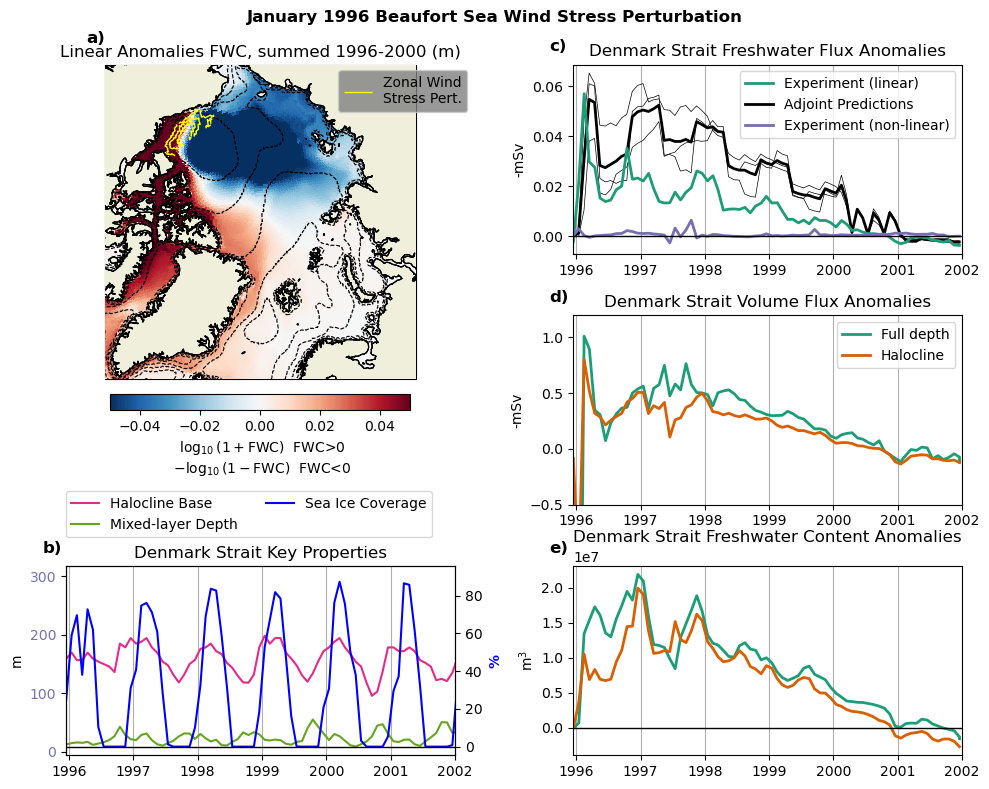

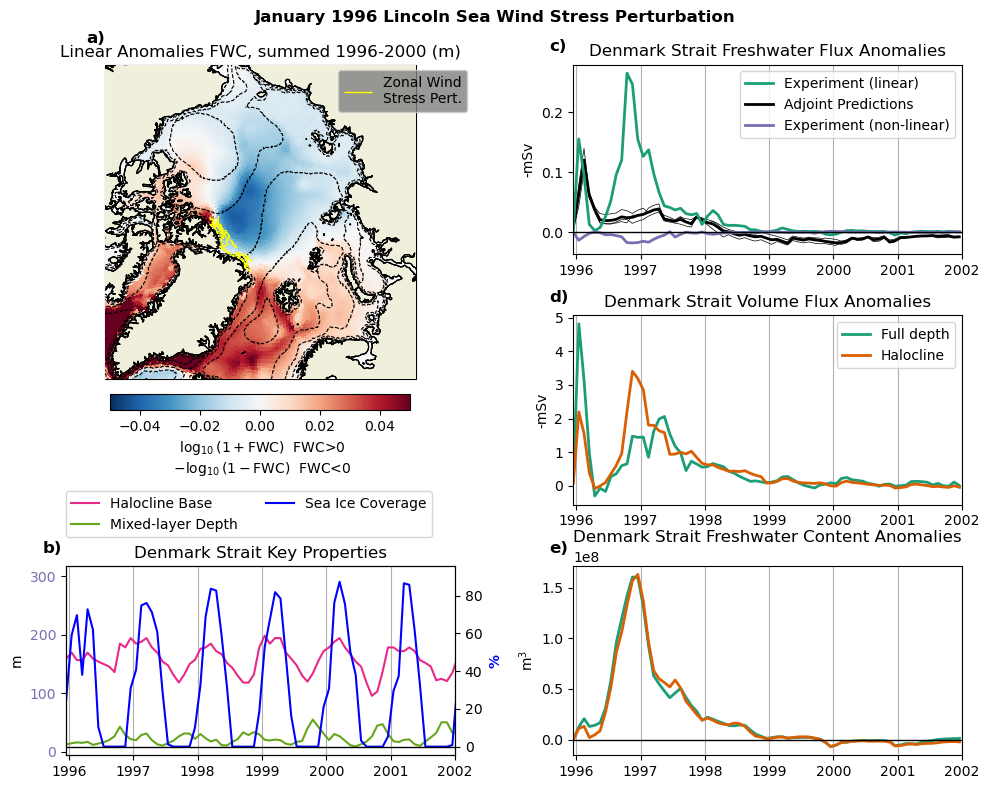

In [13]:
proj_dict={'projection_type':'stereo','lat_lim':67}
colors=plt.get_cmap('Dark2')
label_x=-0.06
label_y=1.07

for iip,pert in enumerate(perts):
    FWC_plot=ds_fw['FWC'].sel(pert='lin',pert_lab=pert).sum('time')
    FWC_plot=xr.where(FWC_plot>0,np.log1p(FWC_plot)/np.log(10),-np.log1p(-FWC_plot)/np.log(10))
    
    fig=plt.figure(figsize=[10,8])

    
    ax1 = plt.subplot2grid((6, 2), (0, 0), rowspan=3, projection=ccrs.NorthPolarStereo())

    [f,ax,p1]=ut.plot_ecco(ecco_grid,pert_mult[pert]*-FWC_plot,
                           cmin=-0.05,cmax=0.05,ax=ax1,show_colorbar=False,
                          **proj_dict,rasterized=True,
                         )
    [f,ax,p2]=ut.plot_ecco(ecco_grid,mean_ssh,ax=ax1,
                           plot_type='contour',colors='k',mapping_method='bin_average',
                           cmap=None,negative_linestyles='dashed',linewidths=0.8,
                           levels=np.arange(-1.4,0,0.10),show_colorbar=False,
                           **proj_dict)
    [f,ax,p3]=ut.plot_ecco(ecco_grid,ds_pert[pert],
                    levels=np.arange(0,0.1,0.1/4),colors='yellow',
                       ax=ax1,
                      **proj_dict,cmap=None,linewidths=1,
                       plot_type='contour',
                      show_colorbar=False
                     )
    plt.title('Linear Anomalies FWC, summed 1996-2000 (m)')
    leg=plt.legend(p3.legend_elements()[0][:1],[f'Zonal Wind\nStress Pert.',],loc=[0.75,0.85],facecolor='grey')
    leg.set_zorder(200)
    cax = fig.add_axes([0.115, 0.48, 0.3, 0.02])
    cb=plt.colorbar(p1,cax=cax,orientation='horizontal',label= " $\log_{10}(1+\mathrm{FWC})$  FWC>0\n $-\log_{10}(1-\mathrm{FWC})$  FWC<0",use_gridspec=False)
    plt.text(label_x,label_y,'a)',transform=ax1.transAxes,fontsize=12,fontweight='bold')
    
    ax2a = plt.subplot2grid((6, 2), (4, 0), rowspan=2)
    p1=(-base_depth).isel(ji=slice(2,9)).mean('ji').plot(lw=1.5,color=colors(3),ax=ax2a)[0]
    p2=ctrl_section['MXLDEPTH'].isel(ji=slice(2,9)).mean('ji').plot(lw=1.5,color=colors(4),ax=ax2a)[0]
    plt.xlabel('')
    plt.title('')
    plt.ylabel('m')
    plt.grid(axis='x')
    ax2a.tick_params(axis='y', labelcolor=colors(2))
    ax2b=ax2a.twinx()
    p3=(100*ctrl_section['SIarea']).isel(ji=slice(2,9)).mean('ji').plot(color='b',lw=1.5,ax=ax2b)[0]
    plt.legend([p1,p2,p3],['Halocline Base','Mixed-layer Depth','Sea Ice Coverage'],loc=[0,1.15],ncol=2)
    plt.xlim([np.datetime64('1995-12-15'),np.datetime64('2002-01-01')])
    plt.title('Denmark Strait Key Properties')
    plt.ylabel('%',color='b',fontweight='bold')
    plt.axhline(0,color='k',lw=1)
    plt.grid(axis='x')
    plt.text(label_x,label_y,'b)',transform=ax2a.transAxes,fontsize=12,fontweight='bold')
    
    ax3 = plt.subplot2grid((6, 2), (0, 1), rowspan=2)
    (pert_mult[pert]*-pred_perts.sel(pert=pert)/1e3).plot(x='plotdate',hue='eyear',color='k',linewidth=0.5, ax=ax3)
    p2=(pert_mult[pert]*-pred_perts.sel(pert=pert)/1e3).mean('eyear').plot(x='plotdate',color='k',linewidth=2, ax=ax3)[0]
    p1=(pert_mult[pert]*delta_lin['fw_trsp'].sel(pert=pert).isel(time=slice(None,-1))).plot(lw=2,color=colors(0), ax=ax3)[0]
    p3=(pert_mult[pert]*delta_non['fw_trsp'].sel(pert=pert).isel(time=slice(None,-1))).plot(lw=2,color=colors(2), ax=ax3)[0]
    plt.legend([p1,p2,p3],['Experiment (linear)','Adjoint Predictions','Experiment (non-linear)'])
    plt.xlabel('')
    plt.ylabel('-mSv')
    plt.xlim([np.datetime64('1995-12-15'),np.datetime64('2002-01-01')])
    plt.title('Denmark Strait Freshwater Flux Anomalies')
    plt.axhline(0,color='k',lw=1)
    plt.grid(axis='x')
    #plt.ylim([-0.005,0.07])
    plt.text(label_x,label_y,'c)',transform=ax3.transAxes,fontsize=12,fontweight='bold')
    
    ax4 = plt.subplot2grid((6, 2), (2, 1), rowspan=2)
    (pert_mult[pert]*perts_2d['vol_trsp'].sel(pert=pert)*1e3).sum('ij').plot(x='time',lw=2,color=colors(0),ax=ax4)
    (pert_mult[pert]*lin2d_base['vol_trsp_z'].sel(pert=pert)*1e3).sum('k').plot(x='time',lw=2,color=colors(1),ax=ax4)
    plt.xlabel('')
    plt.ylabel('-mSv')
    plt.xlim([np.datetime64('1995-12-15'),np.datetime64('2002-01-01')])
    if pert=='NAlaska':
        plt.ylim([-0.5,1.2])
    plt.title('Denmark Strait Volume Flux Anomalies')
    plt.grid(axis='x')
    plt.legend(['Full depth','Halocline'])
    plt.text(label_x,label_y,'d)',transform=ax4.transAxes,fontsize=12,fontweight='bold')
    
    ax5 = plt.subplot2grid((6, 2), (4, 1), rowspan=2)
    (pert_mult[pert]*-ds_section_FWC).sel(pert=pert).plot(lw=2,color=colors(0),ax=ax5)
    (pert_mult[pert]*-lin_FWCz_base).sel(pert=pert).sum('k').plot(lw=2,color=colors(1),ax=ax5)
    plt.xlabel('')
    plt.ylabel('m$^3$')
    plt.xlim([np.datetime64('1995-12-15'),np.datetime64('2002-01-01')])
    plt.title('Denmark Strait Freshwater Content Anomalies')
    plt.grid(axis='x')
    plt.axhline(0,color='k',lw=1)
    plt.text(label_x,label_y,'e)',transform=ax5.transAxes,fontsize=12,fontweight='bold')
    
    plt.suptitle(f'January 1996 {labels[pert]} Wind Stress Perturbation',fontweight='bold')
    plt.tight_layout(h_pad=-1)
    plt.savefig(f'../plots/fig{iip+8}_{flabels[pert]}_pert.pdf',bbox_inches='tight')

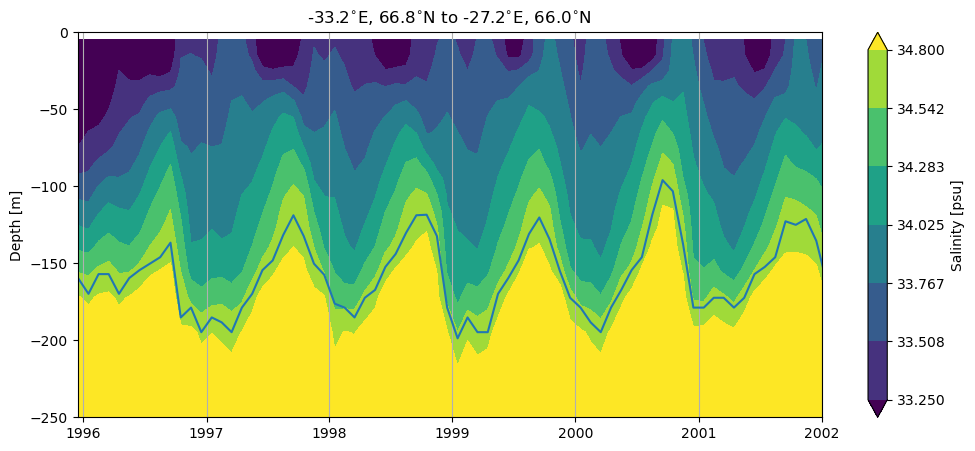

In [15]:
plt.figure(figsize=[12,5])
ctrl_section['SALT'].isel(ji=slice(2,9)).mean('ji').plot.contourf(y='Z',x='time',vmin=33.25,vmax=34.8,cbar_kwargs={'label':'Salinity [psu]'})
base_depth.isel(ji=slice(2,9)).mean('ji').plot(x='time')
plt.ylim([-250,0])
plt.xlim([np.datetime64('1995-12-15'),np.datetime64('2002-01-01')])
plt.ylabel('Depth [m]')
plt.xlabel('')
plt.title(f'{ctrl_section.XC[2]:2.1f}'+'$^{\circ}$E, '+f'{ctrl_section.YC[2]:2.1f}'+'$^{\circ}$N to '+f'{ctrl_section.XC[8]:2.1f}'+'$^{\circ}$E, '+f'{ctrl_section.YC[8]:2.1f}'+'$^{\circ}$N')
plt.grid(axis='x')
plt.savefig(f'../plots/figA1_DenStrait_Salinity.pdf',bbox_inches='tight')

In [16]:
oce_perts=[]
for pert in perts:
    pert_lab=f'tauu_{pert}JANpulse'
    oce_perts.append(xr.open_dataset(f'{DATA_DIR}/perts/pert_10y_{pert_lab}_mon_pertfields.nc').assign_coords({'pert_lab':pert}))
oce_perts=xr.concat(oce_perts,'pert_lab')

In [17]:
seaice_ctrl= ecco.recursive_load_ecco_var_from_years_nc(SOLN_DIR, \
                                           vars_to_load=['SIarea'],years_to_load=1996)

loading files of  SIarea


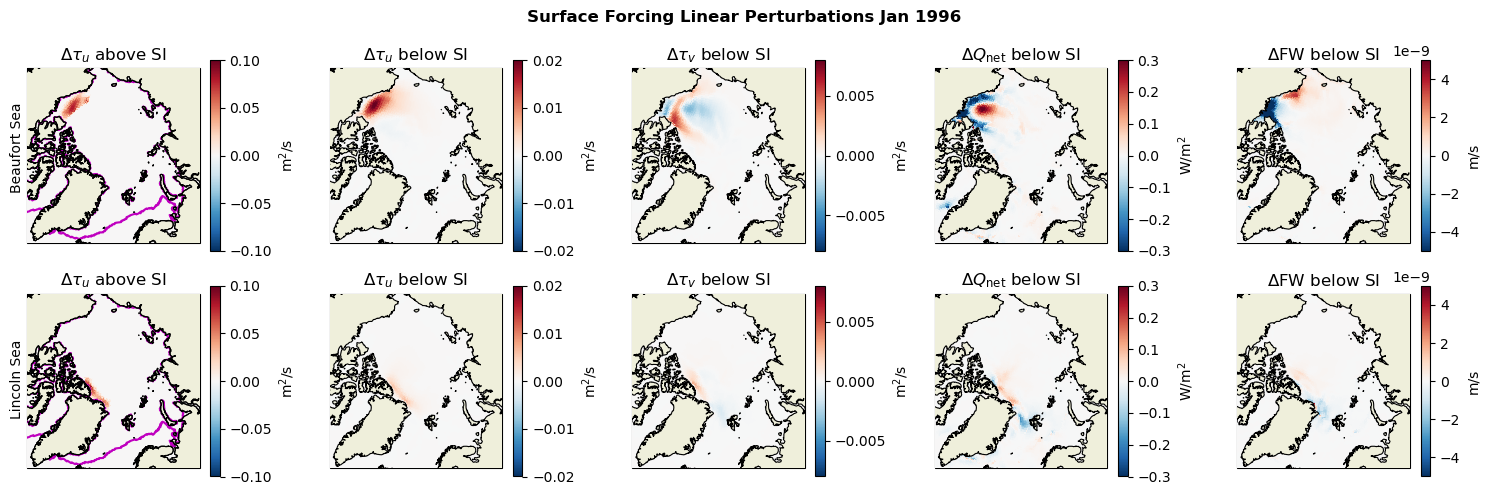

In [32]:
proj_dict={'projection_type':'stereo','lat_lim':67}
tt=4*12
plt.figure(figsize=[15,5])
caxlims={'tauu':0.1,
    'TAUU':0.02,
        'TAUV':0.008,
        'FWflx':0.5e-8,
        'Qnet':0.3}
math_label={'tauu':'$\Delta \\tau_u$',
            'TAUU': '$\Delta \\tau_u$',
        'TAUV':'$\Delta \\tau_v$',
        'FWflx':'$\Delta$FW',
        'Qnet':'$\Delta Q_{\mathrm{net}}$'}

pp=1
for pert in perts:
    for iv,var in enumerate(['EXFtauu','oceTAUU','oceTAUV','oceQnet','oceFWflx']):
        [f,ax,p1]=ut.plot_ecco(ecco_grid,-pert_mult[pert]*oce_perts[var].isel(time=tt).sel(pert_lab=pert,pert='lin').squeeze(),
                                  cmin=-caxlims[var[3:]],cmax=caxlims[var[3:]],
                                  subplot_grid=[2,5,pp],rasterized=True,colorbar_label=exf_units[var],
                                  **proj_dict)
        if iv==0:
            [f,ax,p2]=ut.plot_ecco(ecco_grid,seaice_ctrl.SIarea.isel(time=0).squeeze(),colors='m',
                                   cmap=None,levels=[0.15,],plot_type='contour',ax=ax,
                                   **proj_dict,show_colorbar=False,data_zorder=60)
        if iv==0:
            ax.text(-0.1,0.3,labels[pert],transform=ax.transAxes,rotation=90) 
            ax.set_title(f'{math_label[var[3:]]} above SI')
        else:
            ax.set_title(f'{math_label[var[3:]]} below SI')
        pp+=1
    plt.suptitle(f'Surface Forcing Linear Perturbations Jan 1996',fontsize=12,fontweight='bold')
    plt.tight_layout()
plt.savefig(f'../plots/figS3_Perts_DeltaForcing.pdf',bbox_inches='tight')